In [4]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
import scipy.stats as st
from os.path import expanduser
import cmath
import scipy.optimize as op
import time
import gzip
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition)
%matplotlib inline




In [5]:
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "serif"

start = time.time()

home = os.path.expanduser("~")

direc = os.listdir(".")



In [37]:
def empty(df):
    return len(df.index) == 0
    
def fwhm(valuelist, peakpos,base):
    peakvalue = valuelist[peakpos]-base
    phalf = (peakvalue / 2.0)+base

    # go left and right, starting from peakpos
    ind1 = peakpos
    ind2 = peakpos   

    while ind1>2 and valuelist[ind1]>phalf:
        ind1=ind1-1
    while ind2<len(valuelist)-1 and valuelist[ind2]>phalf:
        ind2=ind2+1  
    return ind1,ind2

def tE_finder (t,f,f_s):
    df = pd.DataFrame({'t' : t, 'f' : f})
    
    A_base = (float(f_s)*0.34)+1
    
    t_max = df['t'][df['f'].argmax()]
    t_right = df['t'][df['t']>t_max]
    t_left = df['t'][df['t']<t_max]
    
    if empty(t_right) == 'False':
        tE_right = np.abs(t_right[(np.abs(df['f'][df['t']>t_max]-(A_base))).argmin()]-t_max)
    else:
        tE_right = 1
    if empty(t_left) == 'False':
        tE_left = np.abs(t_left[(np.abs(df['f'][df['t']<t_max]-(A_base))).argmin()]-t_max)
    else:
        tE_left = 1
    
    return min([tE_right,tE_left])

def fun (t0,u0,tE,f_s):
    u = np.sqrt(u0**2+((df['t']-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    return (f_s * (A-1)) +1
        
def fun2 (mean, sigma,amp, t0,u0,tE,f_s):
    u = np.sqrt(u0**2+((df['t']-t0)/tE)**2)
    A = (((amp/np.sqrt(2*pi*(sigma**2)))*np.exp(-((df['t']-mean)**2)/(2*(sigma**2)))))+((u**2)+2)/(u*np.sqrt((u**2)+4))
    return (f_s * (A-1)) +1

def lnlike(theta, t, f, f_err):
    t0, u0, tE,f_s = theta
    model = fun(t0, u0, tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))

def lnlike2(theta, t, f, f_err):
    mean, sigma,amp, t0,u0,tE,f_s = theta
    model = fun2(mean, sigma,amp, t0,u0,tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
def chisq(theta, t, f, f_err):
    t0, u0, tE,f_s = theta
    model = fun(t0, u0, tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    chii = ((f-model)**2*inv_sigma2)
    
    c = (np.cumsum(chii))
    #c = (c)-N
    #cu_chi= np.cumsum(c)
    #cu_chi = cu_chi/max(cu_chi)
    return c


In [26]:
name = 'cassan_9_62_2163.det.lc.gz'  
tempdata = home+'/Desktop/alllc2/'+str(name)

t,f,f_err,f_true,code = np.loadtxt(tempdata,usecols=(0,1,2,3,5),unpack=True)
df = pd.DataFrame({'t':t , 'f':f , 'f_err' : f_err , 'f_true': f_true, 'code':code})
df = df[df['code']==4]

#df['f'] = df['f_true']

fname = gzip.open(tempdata, 'rb')
x_0 = fname.readlines()[0:7]
f_s_true = x_0[0].split(' ')[4]
q = x_0[5].split(' ')[5]
s = x_0[5].split(' ')[6]
tE_theo = x_0[6].split(' ')[4]
t0_theo = x_0[6].split(' ')[3]
u0_theo = x_0[6].split(' ')[1]



In [27]:
#u0_true = float(f_s_true)/(max(df['f'])-1+float(f_s_true))
A_max = 1.0/(float(f_s_true)/(max(df['f'])-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true =  df['t'][df['f'].argmax()] #float(t0_theo)
ind1, ind2 = fwhm(df['f'],df['f'].argmax(),min(df['f']))
#tE_true = t[ind2]-t[ind1]
tE_true = [tE_finder (df['t'],df[ 'f'], f_s_true),t[ind2]-t[ind1]]
#print 'tE_true = '+ str( tE_true)

tE_ = [[],[]]    
for i in tE_true:
               
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [t0_true, u0_true, i,f_s_true], args=(df['t'],df[ 'f'], df['f_err']),method = 'Nelder-Mead')
    t0_ml, u0_ml, tE_ml,f_s_ml = result['x']
    tE_[0].append(lnlike([t0_ml, u0_ml, tE_ml,f_s_ml],df['t'],df[ 'f'], df['f_err']))
    tE_[1].append([t0_ml, u0_ml, tE_ml,f_s_ml])
            

In [28]:
#print tE_[1]
mm = np.asarray( tE_[0])
tE__ = tE_[1][mm.argmax()]

t0_ml, u0_ml, tE_ml,f_s_ml = tE__[0],tE__[1],tE__[2],tE__[3]

f_ris = df['f']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)
f_ris_true = df['f_true']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)

In [29]:
#u0_true = float(f_s_true)/(max(df['f']-f_ris)-1+float(f_s_true))
A_max = 1.0/(float(f_s_true)/(max(df['f']-f_ris)-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true = df['t'][(df['f']-f_ris).argmax()]

#print 't0_true = ' + str(t0_true)
        

duration = [0.01,0.1,1]  

cut = 100             
# f_ris__ = [(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).max(),(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).min()]
# t_ris__ =  [df['t'][(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).argmax()], df['t'][(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).argmin()]]  
        
f_residual = f_ris
f_ris = smooth(f_ris,10)
f_ris_true = smooth(f_ris_true,19)

if u0_ml>0.7:
    f_ris = smooth(f_ris,19)
    f_ris_true = smooth(f_ris_true,19)

f_ris__ = [f_ris.max(),f_ris.min()]
t_ris__ = [np.asarray(df['t'])[f_ris.argmax()],np.asarray(df['t'])[f_ris.argmin()]]




In [30]:
min_model_ = [[],[]]

for sigma in duration:
            
    for a in range(0,2):        
        amp_ = f_ris__[a]
        #print amp_
        t_mean_ = t_ris__[a]
        
        
        amp_ = amp_ * sigma * np.sqrt(2*pi)
        #print 'sigma = '+str(sigma) + ', amp = '+ str(amp_)
    
        nll = lambda *args: -lnlike2(*args)
        result = op.minimize(nll, [t_mean_,sigma,amp_,t0_ml, u0_ml, tE_ml,f_s_ml], args=(df['t'],df[ 'f'], df['f_err']),method = 'Nelder-Mead')
        mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll = result['x']
        #print result['x']
        min_model_[0].append(lnlike2([mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll],df['t'],df[ 'f'], df['f_err']))
        min_model_[1].append([mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll])


mmm_ = np.asarray( min_model_[0])
final_param = min_model_[1][mmm_.argmax()]       



In [31]:
x_c = np.sqrt((final_param[4]**2)+((final_param[3]-final_param[0])/final_param[5])**2 )

if final_param[2] >0:
    s_exp = (x_c+np.sqrt((x_c**2)+4))/2   
elif final_param[2] <0:
    s_exp = np.abs((x_c-np.sqrt((x_c**2)+4))/2)

In [32]:
del_t = round((np.sqrt(np.abs((float(s)-(1/float(s)))**2 - (float(u0_theo))**2))),2) * float(tE_theo)

right = (round(float(t0_theo)+del_t,2))
left = (round(float(t0_theo)-del_t,2))

cell_text = [[round(float(t0_theo),2), round(final_param[3],2)] ,[round(np.abs(float((u0_theo))),2),round(final_param[4],2)],[round(float(tE_theo),3),round(final_param[5],3)],
             [round(float(f_s_true),3), round(final_param[6],3)],[right, round(final_param[0],2)],
            [round(np.sqrt(float(q))*float(tE_theo),4), round(np.abs(final_param[1]),4)],['Not Known', round(final_param[2],4)]]
        
rows = ('$t_0$','$u_0$','$t_E$','$f_s$','$t_p$','$t_{Ep}$','$a$')   
columns = ('True\n Values','Fitting\n Result')

           
f_res_final = df['f']-fun2(final_param[0],final_param[1],final_param[2],final_param[3],final_param[4],final_param[5],final_param[6])                        
          

In [38]:
chi_2 =  chisq([t0_ml, u0_ml, tE_ml,f_s_ml],df['t'],df[ 'f'], df['f_err'])
N = np.arange(1,len(df['t'])+1)

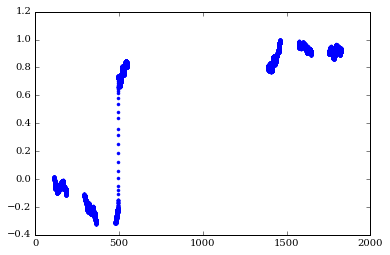

In [45]:
%matplotlib inline
plt.plot(df['t'],((chi_2)-N)/max((chi_2)-N),'b.')


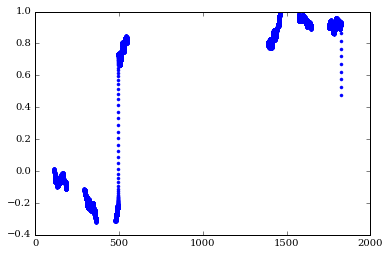

In [47]:
plt.plot(df['t'],smooth(((chi_2)-N)/max((chi_2)-N),19),'b.')

